<a href="https://colab.research.google.com/github/amandusossian/SIR_simulation/blob/main/sir_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#@title Kör detta block för att importera alla paket som behövs

# Imports
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils #Needed to enable "to_categorical" 
np.seterr(invalid='ignore')

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [62]:
#@title Funktioner kopplade till det neurala nätverket. Initialisering, Träning, och genererar förutsägelser

# In this block: setupNN, trainNN, make_predictionsNN, deployNN

def setupNN():
    """This function initializes the nueral network and returns the model""" 
    model = Sequential()  # Define the NN model 
    model.add(Flatten())
    model.add(Dense(50,  activation='relu'))  # Add Layers (Shape kanske inte behövs här?) 
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))  # softmax ensures number between 0-1.
    model.compile(loss = 'mean_squared_error', optimizer='adam', metrics='accuracy')
    return model

def trainNN(model, CR_tensor, test_results):
    """Trains the neural network"""
    reshaped_CR_tensor = np.reshape(CR_tensor, (600,50))
    reshaped_test_results = np.reshape(test_results, 600)
    # Setup the training lists and feed them to the NN
    # Input för NN
    # arry/listan för y_train består av lång lista som korresponderar till x_train där varje index är 0 för frisk eller 1 för sjuk.
    model.fit(reshaped_CR_tensor, reshaped_test_results, epochs=100) #vilken batch size?  #Input för NN, lista, där varje plats är matrix som i artikeln
    # model.evaluate(x_test, y_test, verbose=1
    # model.layers[3].output  # Output för NN, Behöver eventuellt ändra idex beroende på om dropout räknas som lager, vill få output från softmax
    # model.summary() Få tag i info om modellens 

def make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor):
    """Makes predictions with regard to which agents should be tested and isolated.

       Input parameters: R_4, R_8, R_16, total_contact_i, contact_q

       Output: resultNN 
    """
    slicing_list = [(t-j)%10 for j in range(10) ]
    for i in range(n):
        n_tensor[i] = np.array([R_4[(slicing_list, i)], R_8[(slicing_list, i)], R_16[(slicing_list, i)], 
        total_contact_i[(slicing_list, i)], contact_q[(slicing_list, i)]])

    resultNN = model.predict(np.reshape(n_tensor, (n, 50)))
    return resultNN, n_tensor
    # agent_to_peter_index = index_list[t*test_capacity:(t+1)*test_capacity]
 
    #Tensor for prediction regarding all agents

def deployNN(resultNN):
    """Deploys the nueral network by isolated the agents that have a probability over 0.995 to be sicka and
       tests agents with a probability between 0.5 and 0.995. 
    """
    most_plausibly_sick_agents  = np.where(resultNN>0.995)[0]

    maybe_sick_agents = np.where((0.5<resultNN) & (resultNN<=0.995))[0]
    rising_probability_indexes = np.argsort(maybe_sick_agents)
    if len(list(rising_probability_indexes))>30:
        maybe_sick_agents = (rising_probability_indexes[-31:-1])
    else:
        maybe_sick_agents = (rising_probability_indexes)
    return most_plausibly_sick_agents, maybe_sick_agents
    # Gör något med returnerade resultaten också

In [60]:
#@title Funktioner relaterade till utfallen av det neurala nätverkets resultat av förutsägelser


# In this block; peter_test, peter_isolate gen_information_to_peter

def gen_information_to_peter(t, to_be_tested, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor):
    # agent_to_peter_index = index_list[t*test_capacity:(t+1)*test_capacity] # used in sliding window tech
 
    #Tensor for prediction regarding all agents
    slicing_list = [(t-j)%10 for j in range(10) ]
    
 
    for i in range(test_capacity):
        k = to_be_tested[i]
        CR_tensor[t][i] = np.array([R_4[(slicing_list, k)] , R_8[(slicing_list, k)], R_16[(slicing_list, k)], 
        total_contact_i[(slicing_list, k)], contact_q[(slicing_list, k)]])
    
    
    return CR_tensor, CR_tensor[t]
 
def peter_test(peter_test_list, test_capacity, isolated, S):
    
    results_from_peters_test = np.zeros(test_capacity)
    i = 0
    
    for agent in peter_test_list:
        if S[agent] == 1:
            results_from_peters_test[i] = 1
            isolated[agent] = 1
        i +=1
   
    return isolated
 
def peter_isolate(peter_isolate_list, isolated):

    for agent in peter_isolate_list:
        isolated[agent] = 1
    return isolated


In [36]:
#@title Initialiseringsfunktion där alla listor och variabler skapas

# In this block; __init__, init_cr

def __init__(n, l, initial_infected):
    """Initializes almost all parameters connected to the simulation and returns them."""
    x = np.floor(np.random.rand(n) * l)  # x coordinates
    y = np.floor(np.random.rand(n) * l)  # y coordinates
    S = np.zeros(n)  # status array, 0: Susceptiple, 1: Infected, 2: recovered, 3: Dead
    isolated = np.zeros(n)  # Isolation array, 0: not isolated, 1: Is currently in isolation
    temperatures = np.zeros(n, dtype='float16')  # temperature array
    tested = np.zeros(n)
    S[0:initial_infected] = 1  # Infect random agents
    nx = x  # updated x
    ny = y  # updated y
    x_init = x
    y_init = y
    return x, y, x_init, y_init, S, isolated, temperatures, tested, nx, ny

def init_cr(n, test_capacity):
    # Contact matrices
    contact_tot = np.zeros((50, n), dtype='int16')
    contact_i = np.zeros((50, n), dtype='int16')
    total_contact_tot = np.zeros((10, n), dtype='int16')
    total_contact_i = np.zeros((10, n), dtype='int16')
    contact_q = np.zeros((50, n), dtype='float16')
    # R matrices
    R_4 = np.zeros((10, n))
    R_8 = np.zeros((10, n))
    R_16 = np.zeros((10, n))
    

    CR_tensor = np.zeros((20, test_capacity,5,10))
    

    return contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor


In [64]:
#@title Funktion som skapar graf över SIR

# in this block; plot_sir, double_plot

def plot_sir(t, susceptible_history, recovered_history, infected_history, dead_history, isolation_history):
    """Plots the result of the simulation as a figure"""
    index_list_for_plot = np.array([i for i in range(t)])
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    label_susceptible = 'Susceptible = ' + str(susceptible_history[t-1])
    label_recovered = 'Recovered = ' + str(recovered_history[t-1])
    label_infected = 'Infected = ' + str(infected_history[t-1])
    label_dead = 'Dead = ' + str(dead_history[t-1])
    label_isolation = 'Isolation = ' + str(isolation_history[t-1])
    ax.plot(index_list_for_plot, susceptible_history[:t], color='blue', label=label_susceptible)
    ax.plot(index_list_for_plot, recovered_history[:t], color='green', label=label_recovered)
    ax.plot(index_list_for_plot, infected_history[:t], color='red', label=label_infected)
    ax.plot(index_list_for_plot, dead_history[:t], color='purple', label=label_dead)
    ax.plot(index_list_for_plot, isolation_history[:t], color='black', label=label_isolation)
    ax.set_title('Infection plot')
    ax.legend()
    plt.show()

def double_plot(t, susceptible_history, recovered_history, infected_history, dead_history, isolation_history, x,y):
    """Plots the result of the simulation as a figure, 
    as well as the current state of the simulation"""
    index_list_for_plot = np.array([i for i in range(t)])
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 2)
    label_susceptible = 'Susceptible = ' + str(susceptible_history[t-1])
    label_recovered = 'Recovered = ' + str(recovered_history[t-1])
    label_infected = 'Infected = ' + str(infected_history[t-1])
    label_dead = 'Dead = ' + str(dead_history[t-1])
    label_isolation = 'Isolation = ' + str(isolation_history[t-1])
    ax.plot(index_list_for_plot, susceptible_history[:t], color='blue', label=label_susceptible)
    ax.plot(index_list_for_plot, recovered_history[:t], color='green', label=label_recovered)
    ax.plot(index_list_for_plot, infected_history[:t], color='red', label=label_infected)
    ax.plot(index_list_for_plot, dead_history[:t], color='purple', label=label_dead)
    ax.plot(index_list_for_plot, isolation_history[:t], color='black', label=label_isolation)
    ax.set_title('Infection plot')
    ax.legend()
    ax2 = fig.add_subplot(1,2,1)
    ax2.scatter(x,y)
    plt.show()


In [38]:
#@title Generatorfunktionerna för C- och R - matriserna

# In this block; gen_contacts(), gen_R()


def gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q ):
    """Generates the C matrices. The C matrices measure the number of infected agents the agent has 
       been in contact with and the total number of agents the agent has been in contact with. 
    """
    contact_list = np.zeros(n)
    sick_contact_list = np.zeros(n)
 
    coord_list = np.array([2**x[i] * 3**y[i] for i in range(n)])
 
    sick_free_agents = np.where((S == 1) & (isolated != 1))[0]
    non_dead_free_agents = np.where((S != 3) & (isolated != 1))[0]
 
    for infected in sick_free_agents :
        infected_agent = infected
        for other_agent in non_dead_free_agents:
            if (coord_list[infected_agent] == coord_list[other_agent]) & (infected_agent != other_agent):
                sick_contact_list[other_agent] += 1
           
    for i in range(n):
        for hits in np.where((x[i] == x) & (y[i] == y) & (isolated != 1))[0]:
            contact_list[i] += 1
   
 
    contact_i[t % 50] = sick_contact_list
    contact_tot[t % 50] = contact_list

    total_contact_i[t%10] = np.sum(contact_i, 0)
    total_contact_tot[t%10] = np.sum(contact_tot, 0)
 
    contact_q[t % 10] =  np.nan_to_num(np.divide(np.sum(contact_i, 0),np.sum(contact_tot, 0)))
    return contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q 

def gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16):  # Generatorfunktion för R-matriserna
    """Generates the R matrices. The R matrices measure the total number of
       infected agents within a certain radius."""
    temp_r16 = np.zeros(n)
    temp_r8 = np.zeros(n)
    temp_r4 = np.zeros(n)
    r16_squared = 256
    r8_squared = 64
    r4_squared = 16
 
   
    sick_list = np.where((S==1)&(isolated !=1))[0]
    xy_array = np.array([[x[i],y[i]] for i in range(n)])
 
    for sickos in sick_list:
        sick_coords = np.array([x[sickos], y[sickos]])
 
        list_of_16_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r16_squared)
        list_of_8_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r8_squared)
        list_of_4_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r4_squared)
 
        temp_r16[list_of_16_hits] +=1
        temp_r8[list_of_8_hits] +=1
        temp_r4[list_of_4_hits] +=1
   
    # It should not count itself as a person in its vacinity, so remove 1 from the sick indexes
    temp_r16[sick_list] -= 1
    temp_r8[sick_list]  -= 1
    temp_r4[sick_list]  -= 1
 
    R_16[t%10] = temp_r16
    R_8[t%10] = temp_r8
    R_4[t%10] = temp_r4
    return R_4, R_8, R_16

In [39]:
#@title Funktionerna som uppdaterar rörelse och sjukstatus

# In this block; update_position, update_states, set_temps

def update_position(n, x, y, x_init, y_init, isolated, S, nx, ny):
    """Updates the positions of every agent. 
    Returns arrays of the new coordinates of the agents"""

    k = 0.04
    for agent in range(n):
        prob_x = [
            max(0,1/3 +k*(x[agent]-x_init[agent])),
            1/3,
            max(0, 1/3-k*(x[agent]-x_init[agent]))
        ]
        prob_x /= sum(prob_x)
        prob_y = [max(0, 1/3 +k*(y[agent]-y_init[agent])), 1/3, max(0, 1/3-k*(y[agent]-y_init[agent]))]
        prob_y /= sum(prob_y)
        dx = np.random.choice([-1, 0, 1], p=np.array(prob_x))
        dy = np.random.choice([-1, 0, 1], p=np.array(prob_y))
        nx[agent] += dx
        ny[agent] += dy
    for i in np.where(((isolated != 0) | (S == 3)))[0]:
        nx[i] = x[i]
        ny[i] = y[i]
    return nx, ny

    
def update_states(n, isolated, S, temperatures, x, y, B, My, G):
    """Updates the states in the S array of every agent"""
    for i in np.where((isolated != 1) & (S == 1) & (np.random.random(n) < B))[0]:  # loop over infecting agents
        temperatures[(x == x[i]) & (y == y[i]) & (S == 0)] = np.random.normal(40,1)  # Raise newly sick agents temperatures
        S[(x == x[i]) & (y == y[i]) & (S == 0)] = 1  # Susceptiples together with infecting agent becomes infected
    for i in np.where((S == 1) & (np.random.random(n) < My))[0]:
        S[i] = 3
    recovered_list = np.where((S == 1) & (np.random.rand(n) < G))[0]
    S[recovered_list] = 2
    isolated[recovered_list] = 0
    return S

def set_temps(S,n):
    """Gives every agent a random temperature. If the agent is sick the temperature is normally
       distributed around 37.4 and if the agent is not sick 36.8 degrees.
    """
    temperatures = np.zeros(n)
    for i in np.where(S == 1)[0]:
        temperatures[i] = np.random.normal(37.4, 1.2)
 
    for i in np.where(temperatures == 0)[0]:
        temperatures[i] = np.random.normal(36.8, 1.0)
    return temperatures
 

In [40]:
#@title De olika testfunktionerna

# In this block; initial_testing,man_made_test_agents

def initial_testing(t, temperatures, test_capacity, S, isolated, index_list, test_results):
    test_priority = np.argsort(temperatures)
    test_priority = test_priority[-100:-1]
    rand_selected = np.random.randint(0,99,test_capacity)
    to_be_tested = test_priority[rand_selected]
    testing_outcome = np.zeros(test_capacity)
    for agents in range(30):
        if S[to_be_tested[agents]] == 1:
            testing_outcome[agents] = 1
            isolated[to_be_tested[agents]] = 1

    return testing_outcome, to_be_tested

def man_made_test_agents(t, n, contact_i, temperatures, test_capacity, isolated, S):
    # Tests sick agents, if positive test then set in isolation and isolate neighbours in contactmatrix
    if t > 20:
 
        d_type = [('Clist', np.int16), ('Temp', np.float16)]
        test_priority = np.zeros((n,), dtype=d_type)
        test_priority['Clist'] = contact_i[t % 10]
        test_priority['Temp'] = temperatures
        test_priority = np.argsort(test_priority, order=('Clist', 'Temp'))
 
        i = 0
        tests_made = 0
        while tests_made < test_capacity and i < n - 1:  # can't use more tests than allowed, and can't test more agents than there are agents
            test_person = test_priority[-i - 1]
 
            if isolated[test_person] != 1:  # Proceed if the selected agent is not already isolated
                tests_made += 1  # A test is counted
 
                if S[test_person] == 1:  # Isolate sick testsubjects
                    isolated[test_person] = 1
 
            i += 1



In [67]:
#@title Huvuddel av simulationen 


def run_sir(input_list):
   
    # Parameters of the simulation
    n = input_list[0]  # Number of agents
    l = input_list[1]  # Lattice size
    initial_infected = input_list[2]  # Initial infected agents    
    B = input_list[3]
    G = input_list[4]
    D_noll = input_list[6]
    D_reduced = 0.1
    D = D_noll
    My = input_list[5]
    lockdown_enabled = input_list[7]
    start_lock = input_list[8]
    test_capacity = input_list[9]
   
    t = 0
    peter_start_time = 20
    N = 1000  # Simulation time
    
 
 
    #initiate the lists
    x, y, x_init, y_init,  S, isolated, temperatures, tested, nx, ny = __init__(n,l,initial_infected)
    temperatures = set_temps(S,n)
    
    contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor = init_cr(n, test_capacity)
    
    n_tensor = np.zeros((n,5,10))
    information_tensor = np.zeros((20*test_capacity, 5, 10))
    test_results = np.zeros((20,test_capacity))
 
    # output_results = np.zeros(n)
 
    index_list = np.zeros((150*test_capacity))
 
    # Plot lists
 
    susceptible_history =  np.zeros(N)
    infected_history = np.zeros(N)
    recovered_history = np.zeros(N)
    dead_history =  np.zeros(N)
    isolation_history = np.zeros(N)    
   

    model = setupNN()
 
    while t < 1000 and list(np.where(S == 1)[0]):
        nx, ny = update_position(n, x, y, x_init, y_init, isolated, S, nx, ny)
        S = update_states(n, isolated, S, temperatures, x, y, B, My, G)
        contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q = gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q)
        R_4, R_8, R_16 = gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16)
        if t<20:
            testing_outcome, to_be_tested= initial_testing(t, temperatures, test_capacity, S, isolated, index_list, test_results)
            test_results[t] = testing_outcome
            index_list[t*test_capacity:(t+1)*test_capacity] = to_be_tested
            CR_tensor, information_tensor[t*test_capacity:(t+1)*test_capacity] = gen_information_to_peter(t, to_be_tested, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor)
        if t == 20:
            trainNN(model, CR_tensor, test_results)    
        if t>20:
            resultNN, n_tensor = make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor)
            to_isolate, to_test = deployNN(resultNN)
            isolated = peter_isolate(to_isolate, isolated)
            isolated = peter_test(to_test, test_capacity, isolated, S)
        
        # lockdown_enabled loop
        if start_lock < t < start_lock + 200 and lockdown_enabled:
            D = D_reduced
        else:
            D = D_noll
 
        x = nx  # Update x
        y = ny  # Update y
 
        # Used for plotting the graph
        susceptible_history[t] =  len(list(np.where(S == 0)[0]))
        infected_history[t] = len(list(np.where(S == 1)[0]))
        recovered_history[t] = len(list(np.where(S == 2)[0]))
        dead_history[t] =  len(list(np.where(S == 3)[0]))
        isolation_history[t] = len(list(np.where(isolated == 1)[0]))
 
        t += 1
 
        if t % 90 == 0:
            #double_plot(t, susceptible_history, recovered_history, infected_history, dead_history, isolation_history,x,y)
            plot_sir(t, susceptible_history, recovered_history, infected_history, dead_history, isolation_history)

Epoch 1/100
19/19 [==============================] - 1s 2ms/step - loss: 0.3866 - accuracy: 0.4850
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2667 - accuracy: 0.5483
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2510 - accuracy: 0.5700
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2376 - accuracy: 0.5933
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.5933
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.6317
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2226 - accuracy: 0.6333
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.7000
Epoch 9/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2044 - accuracy: 0.6900
Epoch 10/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2116 - accuracy: 0.6817
Epoch 11/

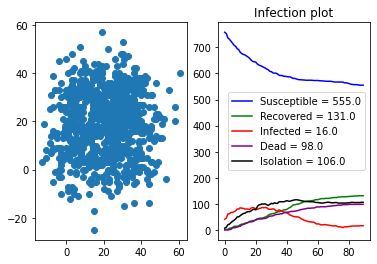

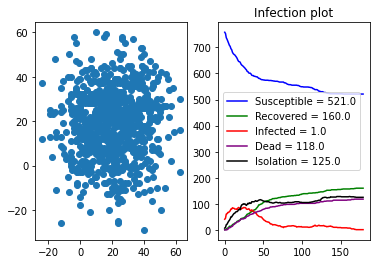

In [66]:
#@title Kör programmet med standardparametrar

# order of the parameters in the list sent to run_sir():
# [ number of agents, lattice size, initially infected, infectionrate, recoveryrate, 
#   deathrate, probability of movement, enable lockdown, starttime of potential lockdown,
#   testcapacity]

# ^^ Kan också lägga in mer, som ex ska NN köras, sliding window

standard_values = [800, 40, 30, 0.6, 0.03, 0.02, 0.8, False, 50, 30]

run_sir(standard_values)

In [ ]:
#@title Kör programmet med egna bestämmda parametrar

for i in range():
    